### Imports and Hyperparameters

In [1]:
import imgaug as ia
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

%matplotlib inline

In [2]:
IMAGE_SIZE = (320, 320)
CLASSES = ['background', 'qr_code']
SHUFFLE_BUFFER = 100
BATCH_SIZE = 16

### A visualization helper function

In [3]:
def display_image(image, boxes=None, box_color=[0, 0, 255], box_thickness=3, ax=None):
    image = np.array(image)
    
    if boxes is not None:
        boxes = np.array(boxes)[..., :5]
        boxes = [ia.BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=CLASSES[int(label)])
                 for x1, y1, x2, y2, label in boxes]
        boxes = ia.BoundingBoxesOnImage(boxes, shape=image.shape)
        image = boxes.draw_on_image(image, color=box_color,
                                    size=box_thickness)
    
    if ax is None:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image)
        ax.axis('off')

### Load and visualize some image

Visualize some images with their boxes for sanity checking 

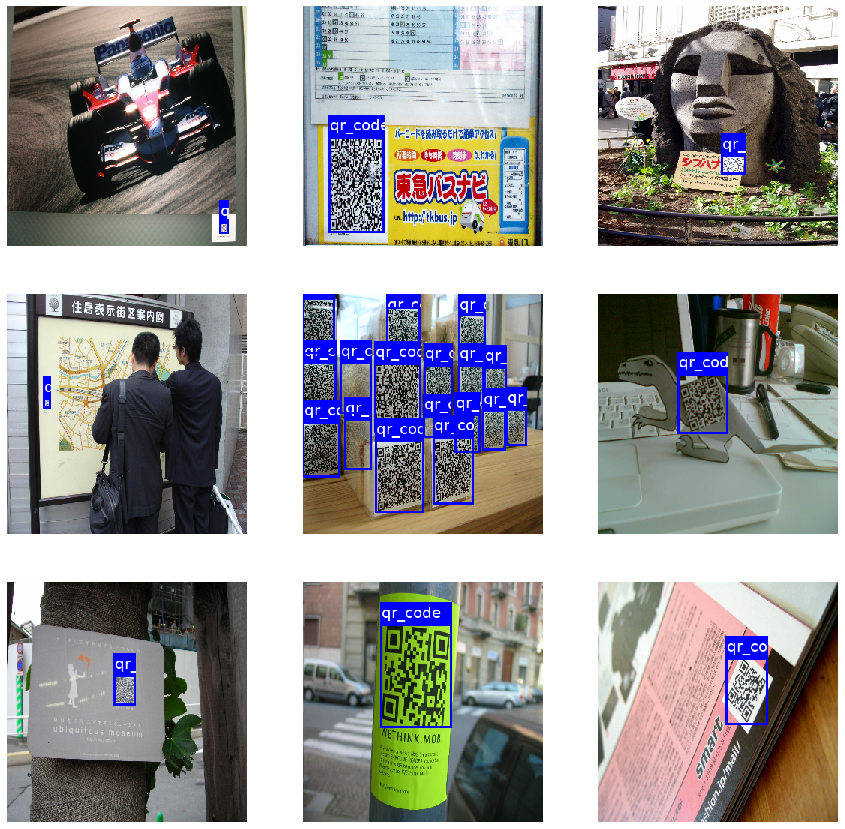

In [4]:
from qr_codes_loader import load_qr_codes_dataset, read_and_resize_image

train_data = load_qr_codes_dataset(split='train')
test_data = load_qr_codes_dataset(split='test')

num_display = 9
num_cols = 3
num_rows = (num_display+1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

#train_data = train_data.batch(10)
data_iter = iter(train_data)

for idx in range(num_display):
    x, y = next(data_iter)
    x, y = read_and_resize_image(x, y, new_size=IMAGE_SIZE)
    display_image(x, y.to_tensor(), ax=fig.axes[idx])
    
plt.show()

### A Callback for running validation and saving the model

In [5]:
from ssd_utils.metrics import mean_AP

class ValidationMeanAPCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_file, anchors, test_dataset, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_file = model_file
        self.anchors = anchors
        self.test_dataset = test_dataset
        self.best_mean_AP = 0
        
    def on_epoch_end(self, epoch, logs=None):
        ground_truth, predictions = [], []
        
        for x, y_true in self.test_dataset:
            predictions += [output_encoder.decode(y, self.anchors, self.model)
                            for y in self.model(x)]
            ground_truth += [y.to_tensor() for y in y_true]
        
        cur_mean_AP = mean_AP(ground_truth, predictions)
        print('Validation meanAP:', cur_mean_AP)
        
        if cur_mean_AP > self.best_mean_AP:
            self.best_mean_AP = cur_mean_AP
            self.model.save_weights(self.model_file)

## MobileNet

### Instantiate the model

In [6]:
from ssd_utils.networks.ssd_mobilenet import SSDMobileNet

model = SSDMobileNet(num_classes=len(CLASSES), name='ssd_mobilenet')

### Encode the data for this model

In [7]:
from ssd_utils import output_encoder

anchors = model.get_anchors(image_shape=IMAGE_SIZE + (3,))

def encode(image, boxes):
    encoded = output_encoder.encode(boxes,
                                    anchors=anchors,
                                    model=model)
    return image, encoded

data_iter = iter(train_data)
x, y = next(data_iter)
x, y = read_and_resize_image(x, y, new_size=IMAGE_SIZE)
x, y = encode(x, y.to_tensor())
print(x.shape, y.shape)

(320, 320, 3) (3000, 6)


### Compile the model and create the data pipeline

In [8]:
from ssd_utils.ssd_loss import SSDLoss

ssd_loss = SSDLoss()
model.compile(optimizer="adam", loss=ssd_loss, run_eagerly=True)


batched_train_data = train_data.shuffle(SHUFFLE_BUFFER,
                                        reshuffle_each_iteration=True)
batched_train_data = batched_train_data.map(lambda x, y:
                read_and_resize_image(x, y, new_size=IMAGE_SIZE))
batched_train_data = batched_train_data.map(lambda x, y:
                tf.py_function(encode, [x, y.to_tensor()], [tf.uint8, tf.float32]))
batched_train_data = batched_train_data.batch(BATCH_SIZE).prefetch(5)


batched_test_data = test_data.map(lambda x, y:
                read_and_resize_image(x, y, new_size=IMAGE_SIZE))
batched_test_data = batched_test_data.batch(BATCH_SIZE)

### The training loop

In [9]:
model.fit(batched_train_data, epochs=100, callbacks=[
    ValidationMeanAPCallback(model_file='baseline_mobilenet.h5',
                             anchors=anchors,
                             test_dataset=batched_test_data)])

Epoch 1/100
Instructions for updating:
Use tf.identity instead.
36/36 [==============================] - ETA: 0s - loss: 25.2373
Calculating Average Precision for class 1.0



Validation meanAP: 0.15894376012154482
36/36 [==============================] - 53s 1s/step - loss: 25.2373
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 3.1476
Calculating Average Precision for class 1.0



Validation meanAP: 0.44969821296980095
36/36 [==============================] - 30s 823ms/step - loss: 3.1476
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 1.3343
Calculating Average Precision for class 1.0



Validation meanAP: 0.5763378090923915
36/36 [==============================] - 28s 775ms/step - loss: 1.3343
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 0.8456
Calculating Average Precision for class 1.0



Validation meanAP: 0.6579198739857197
36/36 [==============================] - 27s 738ms/step - loss: 0.8456
Epoch 5/100
36/36 [==============================] - ETA: 0s - loss: 0.6441
Calculating Average Precision for class 1.0



Validation meanAP: 0.6247989398841172
36/36 [==============================] - 27s 739ms/step - loss: 0.6441
Epoch 6/100
36/36 [==============================] - ETA: 0s - loss: 0.5732
Calculating Average Precision for class 1.0



Validation meanAP: 0.6707003332973089
36/36 [==============================] - 26s 728ms/step - loss: 0.5732
Epoch 7/100
36/36 [==============================] - ETA: 0s - loss: 0.5648
Calculating Average Precision for class 1.0



Validation meanAP: 0.5870694020501092
36/36 [==============================] - 27s 746ms/step - loss: 0.5648
Epoch 8/100
36/36 [==============================] - ETA: 0s - loss: 0.4233
Calculating Average Precision for class 1.0



Validation meanAP: 0.6358527459211765
36/36 [==============================] - 26s 718ms/step - loss: 0.4233
Epoch 9/100
36/36 [==============================] - ETA: 0s - loss: 0.3540
Calculating Average Precision for class 1.0



Validation meanAP: 0.6653342849783881
36/36 [==============================] - 25s 700ms/step - loss: 0.3540
Epoch 10/100
36/36 [==============================] - ETA: 0s - loss: 0.3017
Calculating Average Precision for class 1.0



Validation meanAP: 0.6873966848684765
36/36 [==============================] - 25s 702ms/step - loss: 0.3017
Epoch 11/100
36/36 [==============================] - ETA: 0s - loss: 0.2857
Calculating Average Precision for class 1.0



Validation meanAP: 0.659070733112799
36/36 [==============================] - 25s 691ms/step - loss: 0.2857
Epoch 12/100
36/36 [==============================] - ETA: 0s - loss: 0.2480
Calculating Average Precision for class 1.0



Validation meanAP: 0.6761433022951915
36/36 [==============================] - 25s 705ms/step - loss: 0.2480
Epoch 13/100
36/36 [==============================] - ETA: 0s - loss: 0.2440
Calculating Average Precision for class 1.0



Validation meanAP: 0.6681869040456188
36/36 [==============================] - 25s 699ms/step - loss: 0.2440
Epoch 14/100
36/36 [==============================] - ETA: 0s - loss: 0.2547
Calculating Average Precision for class 1.0



Validation meanAP: 0.6835735733185926
36/36 [==============================] - 25s 703ms/step - loss: 0.2547
Epoch 15/100
36/36 [==============================] - ETA: 0s - loss: 0.2342
Calculating Average Precision for class 1.0



Validation meanAP: 0.6591849221109902
36/36 [==============================] - 25s 698ms/step - loss: 0.2342
Epoch 16/100
36/36 [==============================] - ETA: 0s - loss: 0.2238
Calculating Average Precision for class 1.0



Validation meanAP: 0.6878532845196722
36/36 [==============================] - 25s 704ms/step - loss: 0.2238
Epoch 17/100
36/36 [==============================] - ETA: 0s - loss: 0.1938
Calculating Average Precision for class 1.0



Validation meanAP: 0.6801628107048983
36/36 [==============================] - 25s 688ms/step - loss: 0.1938
Epoch 18/100
36/36 [==============================] - ETA: 0s - loss: 0.1841
Calculating Average Precision for class 1.0



Validation meanAP: 0.6921309957357076
36/36 [==============================] - 26s 713ms/step - loss: 0.1841
Epoch 19/100
36/36 [==============================] - ETA: 0s - loss: 0.1933
Calculating Average Precision for class 1.0



Validation meanAP: 0.6771666200714109
36/36 [==============================] - 25s 706ms/step - loss: 0.1933
Epoch 20/100
36/36 [==============================] - ETA: 0s - loss: 0.1767
Calculating Average Precision for class 1.0



Validation meanAP: 0.6656752383926051
36/36 [==============================] - 26s 722ms/step - loss: 0.1767
Epoch 21/100
36/36 [==============================] - ETA: 0s - loss: 0.1710
Calculating Average Precision for class 1.0



Validation meanAP: 0.7036555146061136
36/36 [==============================] - 30s 840ms/step - loss: 0.1710
Epoch 22/100
36/36 [==============================] - ETA: 0s - loss: 0.1568
Calculating Average Precision for class 1.0



Validation meanAP: 0.6859691508659153
36/36 [==============================] - 28s 772ms/step - loss: 0.1568
Epoch 23/100
36/36 [==============================] - ETA: 0s - loss: 0.1599
Calculating Average Precision for class 1.0



Validation meanAP: 0.6789155286507833
36/36 [==============================] - 27s 745ms/step - loss: 0.1599
Epoch 24/100
36/36 [==============================] - ETA: 0s - loss: 0.1615
Calculating Average Precision for class 1.0



Validation meanAP: 0.6904201323207242
36/36 [==============================] - 30s 846ms/step - loss: 0.1615
Epoch 25/100
36/36 [==============================] - ETA: 0s - loss: 0.1554
Calculating Average Precision for class 1.0



Validation meanAP: 0.6657794769866547
36/36 [==============================] - 28s 787ms/step - loss: 0.1554
Epoch 26/100
36/36 [==============================] - ETA: 0s - loss: 0.1422
Calculating Average Precision for class 1.0



Validation meanAP: 0.6890328255527556
36/36 [==============================] - 26s 724ms/step - loss: 0.1422
Epoch 27/100
36/36 [==============================] - ETA: 0s - loss: 0.1403
Calculating Average Precision for class 1.0



Validation meanAP: 0.6767858280125174
36/36 [==============================] - 26s 732ms/step - loss: 0.1403
Epoch 28/100
36/36 [==============================] - ETA: 0s - loss: 0.1547
Calculating Average Precision for class 1.0



Validation meanAP: 0.6643878595156032
36/36 [==============================] - 25s 705ms/step - loss: 0.1547
Epoch 29/100
36/36 [==============================] - ETA: 0s - loss: 0.1470
Calculating Average Precision for class 1.0



Validation meanAP: 0.6544557339655389
36/36 [==============================] - 26s 709ms/step - loss: 0.1470
Epoch 30/100
36/36 [==============================] - ETA: 0s - loss: 0.1354
Calculating Average Precision for class 1.0



Validation meanAP: 0.6737266394989238
36/36 [==============================] - 27s 754ms/step - loss: 0.1354
Epoch 31/100
36/36 [==============================] - ETA: 0s - loss: 0.1319
Calculating Average Precision for class 1.0



Validation meanAP: 0.6609033049608547
36/36 [==============================] - 28s 774ms/step - loss: 0.1319
Epoch 32/100
36/36 [==============================] - ETA: 0s - loss: 0.1377
Calculating Average Precision for class 1.0



Validation meanAP: 0.6602926879252972
36/36 [==============================] - 30s 834ms/step - loss: 0.1377
Epoch 33/100
36/36 [==============================] - ETA: 0s - loss: 0.1287
Calculating Average Precision for class 1.0



Validation meanAP: 0.6432243650828603
36/36 [==============================] - 26s 730ms/step - loss: 0.1287
Epoch 34/100
36/36 [==============================] - ETA: 0s - loss: 0.1352
Calculating Average Precision for class 1.0



Validation meanAP: 0.6383960097499879
36/36 [==============================] - 27s 755ms/step - loss: 0.1352
Epoch 35/100
36/36 [==============================] - ETA: 0s - loss: 0.1440
Calculating Average Precision for class 1.0



Validation meanAP: 0.6874768701614125
36/36 [==============================] - 28s 787ms/step - loss: 0.1440
Epoch 36/100
36/36 [==============================] - ETA: 0s - loss: 0.1258
Calculating Average Precision for class 1.0



Validation meanAP: 0.7093020720938787
36/36 [==============================] - 25s 705ms/step - loss: 0.1258
Epoch 37/100
36/36 [==============================] - ETA: 0s - loss: 0.1366
Calculating Average Precision for class 1.0



Validation meanAP: 0.6979787538536107
36/36 [==============================] - 26s 713ms/step - loss: 0.1366
Epoch 38/100
36/36 [==============================] - ETA: 0s - loss: 0.1500
Calculating Average Precision for class 1.0



Validation meanAP: 0.7121702729876351
36/36 [==============================] - 26s 720ms/step - loss: 0.1500
Epoch 39/100
36/36 [==============================] - ETA: 0s - loss: 0.1654
Calculating Average Precision for class 1.0



Validation meanAP: 0.6355113976027321
36/36 [==============================] - 27s 740ms/step - loss: 0.1654
Epoch 40/100
36/36 [==============================] - ETA: 0s - loss: 0.3342
Calculating Average Precision for class 1.0



Validation meanAP: 0.6579242524404878
36/36 [==============================] - 26s 718ms/step - loss: 0.3342
Epoch 41/100
36/36 [==============================] - ETA: 0s - loss: 0.2599
Calculating Average Precision for class 1.0



Validation meanAP: 0.6564167879751759
36/36 [==============================] - 27s 737ms/step - loss: 0.2599
Epoch 42/100
36/36 [==============================] - ETA: 0s - loss: 0.2057
Calculating Average Precision for class 1.0



Validation meanAP: 0.6501103331073323
36/36 [==============================] - 28s 770ms/step - loss: 0.2057
Epoch 43/100
36/36 [==============================] - ETA: 0s - loss: 0.1742
Calculating Average Precision for class 1.0



Validation meanAP: 0.6829997610001658
36/36 [==============================] - 27s 746ms/step - loss: 0.1742
Epoch 44/100
36/36 [==============================] - ETA: 0s - loss: 0.1577
Calculating Average Precision for class 1.0



Validation meanAP: 0.6883565884753041
36/36 [==============================] - 26s 727ms/step - loss: 0.1577
Epoch 45/100
36/36 [==============================] - ETA: 0s - loss: 0.1764
Calculating Average Precision for class 1.0



Validation meanAP: 0.6716284606162235
36/36 [==============================] - 25s 700ms/step - loss: 0.1764
Epoch 46/100
36/36 [==============================] - ETA: 0s - loss: 0.1692
Calculating Average Precision for class 1.0



Validation meanAP: 0.6847844289456806
36/36 [==============================] - 25s 696ms/step - loss: 0.1692
Epoch 47/100
36/36 [==============================] - ETA: 0s - loss: 0.1483
Calculating Average Precision for class 1.0



Validation meanAP: 0.7051586669904506
36/36 [==============================] - 26s 711ms/step - loss: 0.1483
Epoch 48/100
36/36 [==============================] - ETA: 0s - loss: 0.1428
Calculating Average Precision for class 1.0



Validation meanAP: 0.6914853469096448
36/36 [==============================] - 25s 700ms/step - loss: 0.1428
Epoch 49/100
36/36 [==============================] - ETA: 0s - loss: 0.1276
Calculating Average Precision for class 1.0



Validation meanAP: 0.7209504674562862
36/36 [==============================] - 25s 701ms/step - loss: 0.1276
Epoch 50/100
36/36 [==============================] - ETA: 0s - loss: 0.1140
Calculating Average Precision for class 1.0



Validation meanAP: 0.706713555117157
36/36 [==============================] - 25s 689ms/step - loss: 0.1140
Epoch 51/100
36/36 [==============================] - ETA: 0s - loss: 0.0968
Calculating Average Precision for class 1.0



Validation meanAP: 0.7122687156894444
36/36 [==============================] - 25s 695ms/step - loss: 0.0968
Epoch 52/100
36/36 [==============================] - ETA: 0s - loss: 0.0925
Calculating Average Precision for class 1.0



Validation meanAP: 0.7156824657531403
36/36 [==============================] - 25s 695ms/step - loss: 0.0925
Epoch 53/100
36/36 [==============================] - ETA: 0s - loss: 0.0905
Calculating Average Precision for class 1.0



Validation meanAP: 0.7261372296711774
36/36 [==============================] - 25s 692ms/step - loss: 0.0905
Epoch 54/100
36/36 [==============================] - ETA: 0s - loss: 0.0855
Calculating Average Precision for class 1.0



Validation meanAP: 0.7051187952507069
36/36 [==============================] - 25s 692ms/step - loss: 0.0855
Epoch 55/100
36/36 [==============================] - ETA: 0s - loss: 0.0908
Calculating Average Precision for class 1.0



Validation meanAP: 0.7185445325998823
36/36 [==============================] - 25s 690ms/step - loss: 0.0908
Epoch 56/100
36/36 [==============================] - ETA: 0s - loss: 0.0891
Calculating Average Precision for class 1.0



Validation meanAP: 0.7257218196140895
36/36 [==============================] - 25s 696ms/step - loss: 0.0891
Epoch 57/100
36/36 [==============================] - ETA: 0s - loss: 0.0831
Calculating Average Precision for class 1.0



Validation meanAP: 0.7290207618953732
36/36 [==============================] - 26s 725ms/step - loss: 0.0831
Epoch 58/100
36/36 [==============================] - ETA: 0s - loss: 0.0816
Calculating Average Precision for class 1.0



Validation meanAP: 0.7136344166179988
36/36 [==============================] - 25s 708ms/step - loss: 0.0816
Epoch 59/100
36/36 [==============================] - ETA: 0s - loss: 0.0777
Calculating Average Precision for class 1.0



Validation meanAP: 0.7174585532167341
36/36 [==============================] - 25s 695ms/step - loss: 0.0777
Epoch 60/100
36/36 [==============================] - ETA: 0s - loss: 0.0776
Calculating Average Precision for class 1.0



Validation meanAP: 0.7249368314290235
36/36 [==============================] - 25s 687ms/step - loss: 0.0776
Epoch 61/100
36/36 [==============================] - ETA: 0s - loss: 0.0809
Calculating Average Precision for class 1.0



Validation meanAP: 0.714325164432245
36/36 [==============================] - 25s 683ms/step - loss: 0.0809
Epoch 62/100
36/36 [==============================] - ETA: 0s - loss: 0.0844
Calculating Average Precision for class 1.0



Validation meanAP: 0.7324609150254087
36/36 [==============================] - 25s 686ms/step - loss: 0.0844
Epoch 63/100
36/36 [==============================] - ETA: 0s - loss: 0.0849
Calculating Average Precision for class 1.0



Validation meanAP: 0.7332014264052291
36/36 [==============================] - 25s 698ms/step - loss: 0.0849
Epoch 64/100
36/36 [==============================] - ETA: 0s - loss: 0.0829
Calculating Average Precision for class 1.0



Validation meanAP: 0.7230311856530476
36/36 [==============================] - 25s 701ms/step - loss: 0.0829
Epoch 65/100
36/36 [==============================] - ETA: 0s - loss: 0.0839
Calculating Average Precision for class 1.0



Validation meanAP: 0.7377173852357835
36/36 [==============================] - 25s 704ms/step - loss: 0.0839
Epoch 66/100
36/36 [==============================] - ETA: 0s - loss: 0.0847
Calculating Average Precision for class 1.0



Validation meanAP: 0.7172519719193913
36/36 [==============================] - 25s 690ms/step - loss: 0.0847
Epoch 67/100
36/36 [==============================] - ETA: 0s - loss: 0.0821
Calculating Average Precision for class 1.0



Validation meanAP: 0.7213483347372069
36/36 [==============================] - 25s 691ms/step - loss: 0.0821
Epoch 68/100
36/36 [==============================] - ETA: 0s - loss: 0.0842
Calculating Average Precision for class 1.0



Validation meanAP: 0.7235265560374329
36/36 [==============================] - 25s 682ms/step - loss: 0.0842
Epoch 69/100
36/36 [==============================] - ETA: 0s - loss: 0.0856
Calculating Average Precision for class 1.0



Validation meanAP: 0.7218598069206963
36/36 [==============================] - 25s 693ms/step - loss: 0.0856
Epoch 70/100
36/36 [==============================] - ETA: 0s - loss: 0.1038
Calculating Average Precision for class 1.0



Validation meanAP: 0.745033317546069
36/36 [==============================] - 25s 696ms/step - loss: 0.1038
Epoch 71/100
36/36 [==============================] - ETA: 0s - loss: 0.0969
Calculating Average Precision for class 1.0



Validation meanAP: 0.7122633384570156
36/36 [==============================] - 25s 693ms/step - loss: 0.0969
Epoch 72/100
36/36 [==============================] - ETA: 0s - loss: 0.0908
Calculating Average Precision for class 1.0



Validation meanAP: 0.7322987636736592
36/36 [==============================] - 25s 698ms/step - loss: 0.0908
Epoch 73/100
36/36 [==============================] - ETA: 0s - loss: 0.0883
Calculating Average Precision for class 1.0



Validation meanAP: 0.7250666199127964
36/36 [==============================] - 25s 691ms/step - loss: 0.0883
Epoch 74/100
36/36 [==============================] - ETA: 0s - loss: 0.1012
Calculating Average Precision for class 1.0



Validation meanAP: 0.7311714157152038
36/36 [==============================] - 25s 687ms/step - loss: 0.1012
Epoch 75/100
36/36 [==============================] - ETA: 0s - loss: 0.0911
Calculating Average Precision for class 1.0



Validation meanAP: 0.7339766065343662
36/36 [==============================] - 25s 695ms/step - loss: 0.0911
Epoch 76/100
36/36 [==============================] - ETA: 0s - loss: 0.1441
Calculating Average Precision for class 1.0



Validation meanAP: 0.7009132476732192
36/36 [==============================] - 25s 689ms/step - loss: 0.1441
Epoch 77/100
36/36 [==============================] - ETA: 0s - loss: 0.0975
Calculating Average Precision for class 1.0



Validation meanAP: 0.7044440679361739
36/36 [==============================] - 25s 686ms/step - loss: 0.0975
Epoch 78/100
36/36 [==============================] - ETA: 0s - loss: 0.0915
Calculating Average Precision for class 1.0



Validation meanAP: 0.7136889130774564
36/36 [==============================] - 24s 678ms/step - loss: 0.0915
Epoch 79/100
36/36 [==============================] - ETA: 0s - loss: 0.0910
Calculating Average Precision for class 1.0



Validation meanAP: 0.7171432103400954
36/36 [==============================] - 25s 687ms/step - loss: 0.0910
Epoch 80/100
36/36 [==============================] - ETA: 0s - loss: 0.0939
Calculating Average Precision for class 1.0



Validation meanAP: 0.7176695309634235
36/36 [==============================] - 25s 695ms/step - loss: 0.0939
Epoch 81/100
36/36 [==============================] - ETA: 0s - loss: 0.0877
Calculating Average Precision for class 1.0



Validation meanAP: 0.719873774574961
36/36 [==============================] - 25s 687ms/step - loss: 0.0877
Epoch 82/100
36/36 [==============================] - ETA: 0s - loss: 0.0870
Calculating Average Precision for class 1.0



Validation meanAP: 0.7326515875982058
36/36 [==============================] - 24s 679ms/step - loss: 0.0870
Epoch 83/100
36/36 [==============================] - ETA: 0s - loss: 0.0852
Calculating Average Precision for class 1.0



Validation meanAP: 0.7303734108365749
36/36 [==============================] - 25s 688ms/step - loss: 0.0852
Epoch 84/100
36/36 [==============================] - ETA: 0s - loss: 0.0769
Calculating Average Precision for class 1.0



Validation meanAP: 0.7269001311265892
36/36 [==============================] - 25s 685ms/step - loss: 0.0769
Epoch 85/100
36/36 [==============================] - ETA: 0s - loss: 0.0734
Calculating Average Precision for class 1.0



Validation meanAP: 0.7158801353747576
36/36 [==============================] - 25s 687ms/step - loss: 0.0734
Epoch 86/100
36/36 [==============================] - ETA: 0s - loss: 0.0697
Calculating Average Precision for class 1.0



Validation meanAP: 0.7114529280031214
36/36 [==============================] - 25s 692ms/step - loss: 0.0697
Epoch 87/100
36/36 [==============================] - ETA: 0s - loss: 0.0706
Calculating Average Precision for class 1.0



Validation meanAP: 0.7099517267585093
36/36 [==============================] - 25s 688ms/step - loss: 0.0706
Epoch 88/100
36/36 [==============================] - ETA: 0s - loss: 0.0759
Calculating Average Precision for class 1.0



Validation meanAP: 0.7262000458399347
36/36 [==============================] - 25s 688ms/step - loss: 0.0759
Epoch 89/100
36/36 [==============================] - ETA: 0s - loss: 0.0688
Calculating Average Precision for class 1.0



Validation meanAP: 0.7119336544843791
36/36 [==============================] - 25s 688ms/step - loss: 0.0688
Epoch 90/100
36/36 [==============================] - ETA: 0s - loss: 0.0712
Calculating Average Precision for class 1.0



Validation meanAP: 0.722141386899521
36/36 [==============================] - 25s 687ms/step - loss: 0.0712
Epoch 91/100
36/36 [==============================] - ETA: 0s - loss: 0.0809
Calculating Average Precision for class 1.0



Validation meanAP: 0.7347154962346072
36/36 [==============================] - 25s 689ms/step - loss: 0.0809
Epoch 92/100
36/36 [==============================] - ETA: 0s - loss: 0.0769
Calculating Average Precision for class 1.0



Validation meanAP: 0.7373680908910019
36/36 [==============================] - 25s 689ms/step - loss: 0.0769
Epoch 93/100
36/36 [==============================] - ETA: 0s - loss: 0.0737
Calculating Average Precision for class 1.0



Validation meanAP: 0.7380754333244004
36/36 [==============================] - 25s 695ms/step - loss: 0.0737
Epoch 94/100
36/36 [==============================] - ETA: 0s - loss: 0.0712
Calculating Average Precision for class 1.0



Validation meanAP: 0.7362620688782309
36/36 [==============================] - 24s 677ms/step - loss: 0.0712
Epoch 95/100
36/36 [==============================] - ETA: 0s - loss: 0.0683
Calculating Average Precision for class 1.0



Validation meanAP: 0.7356115073864369
36/36 [==============================] - 25s 686ms/step - loss: 0.0683
Epoch 96/100
36/36 [==============================] - ETA: 0s - loss: 0.0685
Calculating Average Precision for class 1.0



Validation meanAP: 0.7577284745953049
36/36 [==============================] - 24s 678ms/step - loss: 0.0685
Epoch 97/100
36/36 [==============================] - ETA: 0s - loss: 0.0678
Calculating Average Precision for class 1.0



Validation meanAP: 0.7416692131208191
36/36 [==============================] - 25s 693ms/step - loss: 0.0678
Epoch 98/100
36/36 [==============================] - ETA: 0s - loss: 0.0722
Calculating Average Precision for class 1.0



Validation meanAP: 0.7435441555107809
36/36 [==============================] - 25s 686ms/step - loss: 0.0722
Epoch 99/100
36/36 [==============================] - ETA: 0s - loss: 0.0788
Calculating Average Precision for class 1.0



Validation meanAP: 0.7494903780273419
36/36 [==============================] - 25s 693ms/step - loss: 0.0788
Epoch 100/100
36/36 [==============================] - ETA: 0s - loss: 0.1004
Calculating Average Precision for class 1.0



Validation meanAP: 0.7400574081167601
36/36 [==============================] - 25s 686ms/step - loss: 0.1004



Calculating Average Precision for class 1.0



Validation meanAP: 0.763051676965097


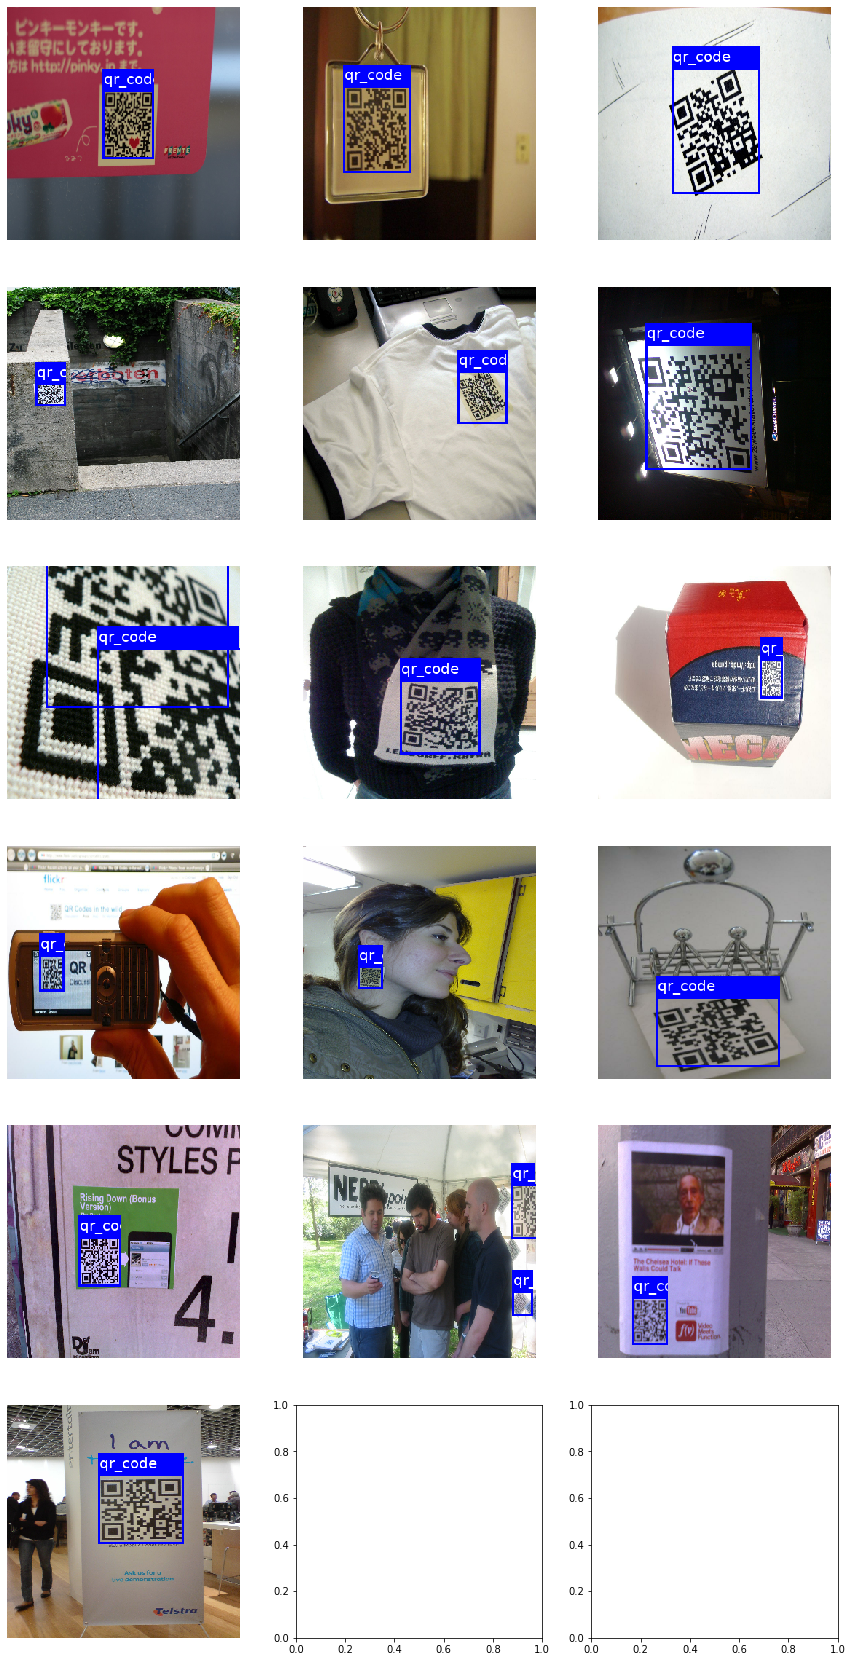

In [10]:
model_file = 'baseline_mobilenet.h5'
model.load_weights(model_file)

from ssd_utils.metrics import mean_AP

ground_truth, predictions = [], []
        
for x, y_true in batched_test_data:
    predictions += [output_encoder.decode(y, anchors, model, nms_threshold=0.2)
                    for y in model(x)]
    ground_truth += [y.to_tensor() for y in y_true]

print('Validation meanAP:', mean_AP(ground_truth, predictions))

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(batched_test_data)
X, Y = next(data_iter)

for idx in range(num_display):
    x, y = X[idx], predictions[idx]
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()

## ResNet50

### Instantiate the model

In [12]:
x, y = next(iter(batched_train_data))
print(x.shape, y.shape)

(16, 320, 320, 3) (16, 3000, 6)


In [11]:
from ssd_utils.networks.ssd_resnet50 import SSDResNet50

model = SSDResNet50(num_classes=len(CLASSES), name='ssd_resnet50')

### Encode the data for this model

In [15]:
from ssd_utils import output_encoder

anchors = model.get_anchors(image_shape=IMAGE_SIZE + (3,))

def encode(image, boxes):
    encoded = output_encoder.encode(boxes,
                                    anchors=anchors,
                                    model=model)
    return image, encoded

data_iter = iter(train_data)
x, y = next(data_iter)
x, y = read_and_resize_image(x, y, new_size=IMAGE_SIZE)
x, y = encode(x, y.to_tensor())
print(x.shape, y.shape)

(320, 320, 3) (4500, 6)


### Compile the model and create the data pipeline

In [16]:
from ssd_utils.ssd_loss import SSDLoss

ssd_loss = SSDLoss()
model.compile(optimizer="adam", loss=ssd_loss, run_eagerly=True)


batched_train_data = train_data.shuffle(SHUFFLE_BUFFER,
                                        reshuffle_each_iteration=True)
batched_train_data = batched_train_data.map(lambda x, y:
                read_and_resize_image(x, y, new_size=IMAGE_SIZE))
batched_train_data = batched_train_data.map(lambda x, y:
                tf.py_function(encode, [x, y.to_tensor()], [tf.uint8, tf.float32]))
batched_train_data = batched_train_data.batch(BATCH_SIZE).prefetch(5)


batched_test_data = test_data.map(lambda x, y:
                read_and_resize_image(x, y, new_size=IMAGE_SIZE))
batched_test_data = batched_test_data.batch(BATCH_SIZE)

### The training loop

In [17]:
model.fit(batched_train_data, epochs=100, callbacks=[
    ValidationMeanAPCallback(model_file='baseline_resnet50.h5',
                             anchors=anchors,
                             test_dataset=batched_test_data)])

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 29.6648
Calculating Average Precision for class 1.0



Validation meanAP: 0.0
36/36 [==============================] - 38s 1s/step - loss: 29.6648
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 2.8105
Calculating Average Precision for class 1.0



Validation meanAP: 0.16973099336824404
36/36 [==============================] - 38s 1s/step - loss: 2.8105
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 1.8245
Calculating Average Precision for class 1.0



Validation meanAP: 0.3554030613144008
36/36 [==============================] - 37s 1s/step - loss: 1.8245
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 1.3268
Calculating Average Precision for class 1.0



Validation meanAP: 0.4642821626438084
36/36 [==============================] - 38s 1s/step - loss: 1.3268
Epoch 5/100
36/36 [==============================] - ETA: 0s - loss: 1.0397
Calculating Average Precision for class 1.0



Validation meanAP: 0.5506745094528204
36/36 [==============================] - 39s 1s/step - loss: 1.0397
Epoch 6/100
36/36 [==============================] - ETA: 0s - loss: 0.8748
Calculating Average Precision for class 1.0



Validation meanAP: 0.601428587641446
36/36 [==============================] - 39s 1s/step - loss: 0.8748
Epoch 7/100
36/36 [==============================] - ETA: 0s - loss: 0.7582
Calculating Average Precision for class 1.0



Validation meanAP: 0.6255007076596594
36/36 [==============================] - 38s 1s/step - loss: 0.7582
Epoch 8/100
36/36 [==============================] - ETA: 0s - loss: 0.5837
Calculating Average Precision for class 1.0



Validation meanAP: 0.6455045080946171
36/36 [==============================] - 39s 1s/step - loss: 0.5837
Epoch 9/100
36/36 [==============================] - ETA: 0s - loss: 0.5486
Calculating Average Precision for class 1.0



Validation meanAP: 0.6588290565535281
36/36 [==============================] - 38s 1s/step - loss: 0.5486
Epoch 10/100
36/36 [==============================] - ETA: 0s - loss: 0.5162
Calculating Average Precision for class 1.0



Validation meanAP: 0.7007731274350284
36/36 [==============================] - 38s 1s/step - loss: 0.5162
Epoch 11/100
36/36 [==============================] - ETA: 0s - loss: 0.4929
Calculating Average Precision for class 1.0



Validation meanAP: 0.6754961535048382
36/36 [==============================] - 37s 1s/step - loss: 0.4929
Epoch 12/100
36/36 [==============================] - ETA: 0s - loss: 0.4729
Calculating Average Precision for class 1.0



Validation meanAP: 0.6554613744570938
36/36 [==============================] - 37s 1s/step - loss: 0.4729
Epoch 13/100
36/36 [==============================] - ETA: 0s - loss: 0.4310
Calculating Average Precision for class 1.0



Validation meanAP: 0.6686716296901706
36/36 [==============================] - 37s 1s/step - loss: 0.4310
Epoch 14/100
36/36 [==============================] - ETA: 0s - loss: 0.4086
Calculating Average Precision for class 1.0



Validation meanAP: 0.7000668136276158
36/36 [==============================] - 37s 1s/step - loss: 0.4086
Epoch 15/100
36/36 [==============================] - ETA: 0s - loss: 0.3781
Calculating Average Precision for class 1.0



Validation meanAP: 0.7021197904008225
36/36 [==============================] - 38s 1s/step - loss: 0.3781
Epoch 16/100
36/36 [==============================] - ETA: 0s - loss: 0.3500
Calculating Average Precision for class 1.0



Validation meanAP: 0.6418900074559178
36/36 [==============================] - 37s 1s/step - loss: 0.3500
Epoch 17/100
36/36 [==============================] - ETA: 0s - loss: 0.3315
Calculating Average Precision for class 1.0



Validation meanAP: 0.6957908799293102
36/36 [==============================] - 37s 1s/step - loss: 0.3315
Epoch 18/100
36/36 [==============================] - ETA: 0s - loss: 0.3029
Calculating Average Precision for class 1.0



Validation meanAP: 0.682122176762971
36/36 [==============================] - 37s 1s/step - loss: 0.3029
Epoch 19/100
36/36 [==============================] - ETA: 0s - loss: 0.2871
Calculating Average Precision for class 1.0



Validation meanAP: 0.674726933310729
36/36 [==============================] - 37s 1s/step - loss: 0.2871
Epoch 20/100
36/36 [==============================] - ETA: 0s - loss: 0.2551
Calculating Average Precision for class 1.0



Validation meanAP: 0.6792224254200697
36/36 [==============================] - 37s 1s/step - loss: 0.2551
Epoch 21/100
36/36 [==============================] - ETA: 0s - loss: 0.2829
Calculating Average Precision for class 1.0



Validation meanAP: 0.6653614899533031
36/36 [==============================] - 37s 1s/step - loss: 0.2829
Epoch 22/100
36/36 [==============================] - ETA: 0s - loss: 0.2699
Calculating Average Precision for class 1.0



Validation meanAP: 0.6525047369555482
36/36 [==============================] - 37s 1s/step - loss: 0.2699
Epoch 23/100
36/36 [==============================] - ETA: 0s - loss: 0.2636
Calculating Average Precision for class 1.0



Validation meanAP: 0.6506440629568105
36/36 [==============================] - 37s 1s/step - loss: 0.2636
Epoch 24/100
36/36 [==============================] - ETA: 0s - loss: 0.2536
Calculating Average Precision for class 1.0



Validation meanAP: 0.6667124482515668
36/36 [==============================] - 37s 1s/step - loss: 0.2536
Epoch 25/100
36/36 [==============================] - ETA: 0s - loss: 0.2303
Calculating Average Precision for class 1.0



Validation meanAP: 0.6530181158777288
36/36 [==============================] - 36s 1s/step - loss: 0.2303
Epoch 26/100
36/36 [==============================] - ETA: 0s - loss: 0.2201
Calculating Average Precision for class 1.0



Validation meanAP: 0.6394785635874471
36/36 [==============================] - 36s 1s/step - loss: 0.2201
Epoch 27/100
36/36 [==============================] - ETA: 0s - loss: 0.2075
Calculating Average Precision for class 1.0



Validation meanAP: 0.6641672990917629
36/36 [==============================] - 37s 1s/step - loss: 0.2075
Epoch 28/100
36/36 [==============================] - ETA: 0s - loss: 0.2016
Calculating Average Precision for class 1.0



Validation meanAP: 0.6460196758663919
36/36 [==============================] - 36s 1s/step - loss: 0.2016
Epoch 29/100
36/36 [==============================] - ETA: 0s - loss: 0.2069
Calculating Average Precision for class 1.0



Validation meanAP: 0.6549175732380096
36/36 [==============================] - 37s 1s/step - loss: 0.2069
Epoch 30/100
36/36 [==============================] - ETA: 0s - loss: 0.1793
Calculating Average Precision for class 1.0



Validation meanAP: 0.6631327568257649
36/36 [==============================] - 36s 1s/step - loss: 0.1793
Epoch 31/100
36/36 [==============================] - ETA: 0s - loss: 0.1732
Calculating Average Precision for class 1.0



Validation meanAP: 0.6560401331981576
36/36 [==============================] - 36s 1s/step - loss: 0.1732
Epoch 32/100
36/36 [==============================] - ETA: 0s - loss: 0.1727
Calculating Average Precision for class 1.0



Validation meanAP: 0.6689089020044459
36/36 [==============================] - 37s 1s/step - loss: 0.1727
Epoch 33/100
36/36 [==============================] - ETA: 0s - loss: 0.1697
Calculating Average Precision for class 1.0



Validation meanAP: 0.6667417396374595
36/36 [==============================] - 37s 1s/step - loss: 0.1697
Epoch 34/100
36/36 [==============================] - ETA: 0s - loss: 0.1588
Calculating Average Precision for class 1.0



Validation meanAP: 0.673695669591929
36/36 [==============================] - 37s 1s/step - loss: 0.1588
Epoch 35/100
36/36 [==============================] - ETA: 0s - loss: 0.1483
Calculating Average Precision for class 1.0



Validation meanAP: 0.6715775482203853
36/36 [==============================] - 37s 1s/step - loss: 0.1483
Epoch 36/100
36/36 [==============================] - ETA: 0s - loss: 0.1518
Calculating Average Precision for class 1.0



Validation meanAP: 0.6592748033687532
36/36 [==============================] - 37s 1s/step - loss: 0.1518
Epoch 37/100
36/36 [==============================] - ETA: 0s - loss: 0.1462
Calculating Average Precision for class 1.0



Validation meanAP: 0.6667358882216291
36/36 [==============================] - 37s 1s/step - loss: 0.1462
Epoch 38/100
36/36 [==============================] - ETA: 0s - loss: 0.1406
Calculating Average Precision for class 1.0



Validation meanAP: 0.6635227684769297
36/36 [==============================] - 38s 1s/step - loss: 0.1406
Epoch 39/100
36/36 [==============================] - ETA: 0s - loss: 0.1334
Calculating Average Precision for class 1.0



Validation meanAP: 0.6734443094014165
36/36 [==============================] - 37s 1s/step - loss: 0.1334
Epoch 40/100
36/36 [==============================] - ETA: 0s - loss: 0.1513
Calculating Average Precision for class 1.0



Validation meanAP: 0.6553577497317207
36/36 [==============================] - 37s 1s/step - loss: 0.1513
Epoch 41/100
36/36 [==============================] - ETA: 0s - loss: 0.1521
Calculating Average Precision for class 1.0



Validation meanAP: 0.6754410306669867
36/36 [==============================] - 36s 1s/step - loss: 0.1521
Epoch 42/100
36/36 [==============================] - ETA: 0s - loss: 0.1602
Calculating Average Precision for class 1.0



Validation meanAP: 0.6506627297966185
36/36 [==============================] - 37s 1s/step - loss: 0.1602
Epoch 43/100
36/36 [==============================] - ETA: 0s - loss: 0.1593
Calculating Average Precision for class 1.0



Validation meanAP: 0.6540297673665065
36/36 [==============================] - 37s 1s/step - loss: 0.1593
Epoch 44/100
36/36 [==============================] - ETA: 0s - loss: 0.1453
Calculating Average Precision for class 1.0



Validation meanAP: 0.6689883242875647
36/36 [==============================] - 36s 1s/step - loss: 0.1453
Epoch 45/100
36/36 [==============================] - ETA: 0s - loss: 0.1579
Calculating Average Precision for class 1.0



Validation meanAP: 0.651397771345305
36/36 [==============================] - 37s 1s/step - loss: 0.1579
Epoch 46/100
36/36 [==============================] - ETA: 0s - loss: 0.1568
Calculating Average Precision for class 1.0



Validation meanAP: 0.6617513665409543
36/36 [==============================] - 37s 1s/step - loss: 0.1568
Epoch 47/100
36/36 [==============================] - ETA: 0s - loss: 0.1490
Calculating Average Precision for class 1.0



Validation meanAP: 0.6685632650645909
36/36 [==============================] - 37s 1s/step - loss: 0.1490
Epoch 48/100
36/36 [==============================] - ETA: 0s - loss: 0.1804
Calculating Average Precision for class 1.0



Validation meanAP: 0.6960091669924626
36/36 [==============================] - 37s 1s/step - loss: 0.1804
Epoch 49/100
36/36 [==============================] - ETA: 0s - loss: 0.1757
Calculating Average Precision for class 1.0



Validation meanAP: 0.6747207804251666
36/36 [==============================] - 37s 1s/step - loss: 0.1757
Epoch 50/100
36/36 [==============================] - ETA: 0s - loss: 0.1695
Calculating Average Precision for class 1.0



Validation meanAP: 0.6589514256780007
36/36 [==============================] - 38s 1s/step - loss: 0.1695
Epoch 51/100
36/36 [==============================] - ETA: 0s - loss: 0.1661
Calculating Average Precision for class 1.0



Validation meanAP: 0.6661903932069337
36/36 [==============================] - 38s 1s/step - loss: 0.1661
Epoch 52/100
36/36 [==============================] - ETA: 0s - loss: 0.5517
Calculating Average Precision for class 1.0



Validation meanAP: 0.04006555153707052
36/36 [==============================] - 36s 1s/step - loss: 0.5517
Epoch 53/100
36/36 [==============================] - ETA: 0s - loss: 2.9461
Calculating Average Precision for class 1.0



Validation meanAP: 0.0
36/36 [==============================] - 36s 993ms/step - loss: 2.9461
Epoch 54/100
36/36 [==============================] - ETA: 0s - loss: 5.5936
Calculating Average Precision for class 1.0



Validation meanAP: 0.0
36/36 [==============================] - 36s 994ms/step - loss: 5.5936
Epoch 55/100
36/36 [==============================] - ETA: 0s - loss: 2.3807
Calculating Average Precision for class 1.0



Validation meanAP: 0.0
36/36 [==============================] - 36s 993ms/step - loss: 2.3807
Epoch 56/100
36/36 [==============================] - ETA: 0s - loss: 1.7773
Calculating Average Precision for class 1.0



Validation meanAP: 0.18458256714798785
36/36 [==============================] - 38s 1s/step - loss: 1.7773
Epoch 57/100
36/36 [==============================] - ETA: 0s - loss: 1.2515
Calculating Average Precision for class 1.0



Validation meanAP: 0.4199225233911024
36/36 [==============================] - 37s 1s/step - loss: 1.2515
Epoch 58/100
36/36 [==============================] - ETA: 0s - loss: 1.0800
Calculating Average Precision for class 1.0



Validation meanAP: 0.5827103661033435
36/36 [==============================] - 37s 1s/step - loss: 1.0800
Epoch 59/100
36/36 [==============================] - ETA: 0s - loss: 0.9164
Calculating Average Precision for class 1.0



Validation meanAP: 0.5665199645557928
36/36 [==============================] - 37s 1s/step - loss: 0.9164
Epoch 60/100
36/36 [==============================] - ETA: 0s - loss: 0.7452
Calculating Average Precision for class 1.0



Validation meanAP: 0.5732314376192533
36/36 [==============================] - 36s 1s/step - loss: 0.7452
Epoch 61/100
36/36 [==============================] - ETA: 0s - loss: 0.7338
Calculating Average Precision for class 1.0



Validation meanAP: 0.5897890387977123
36/36 [==============================] - 36s 1s/step - loss: 0.7338
Epoch 62/100
36/36 [==============================] - ETA: 0s - loss: 0.6411
Calculating Average Precision for class 1.0



Validation meanAP: 0.573512795919915
36/36 [==============================] - 37s 1s/step - loss: 0.6411
Epoch 63/100
36/36 [==============================] - ETA: 0s - loss: 0.5923
Calculating Average Precision for class 1.0



Validation meanAP: 0.5902915851982785
36/36 [==============================] - 37s 1s/step - loss: 0.5923
Epoch 64/100
36/36 [==============================] - ETA: 0s - loss: 0.5010
Calculating Average Precision for class 1.0



Validation meanAP: 0.595690085588255
36/36 [==============================] - 37s 1s/step - loss: 0.5010
Epoch 65/100
36/36 [==============================] - ETA: 0s - loss: 0.4542
Calculating Average Precision for class 1.0



Validation meanAP: 0.6044069174637541
36/36 [==============================] - 37s 1s/step - loss: 0.4542
Epoch 66/100
36/36 [==============================] - ETA: 0s - loss: 0.4654
Calculating Average Precision for class 1.0



Validation meanAP: 0.6241678132901914
36/36 [==============================] - 37s 1s/step - loss: 0.4654
Epoch 67/100
36/36 [==============================] - ETA: 0s - loss: 0.3911
Calculating Average Precision for class 1.0



Validation meanAP: 0.621958558852676
36/36 [==============================] - 36s 1s/step - loss: 0.3911
Epoch 68/100
36/36 [==============================] - ETA: 0s - loss: 0.3520
Calculating Average Precision for class 1.0



Validation meanAP: 0.5773859011934122
36/36 [==============================] - 37s 1s/step - loss: 0.3520
Epoch 69/100
36/36 [==============================] - ETA: 0s - loss: 0.3241
Calculating Average Precision for class 1.0



Validation meanAP: 0.5946365241834358
36/36 [==============================] - 37s 1s/step - loss: 0.3241
Epoch 70/100
36/36 [==============================] - ETA: 0s - loss: 0.3249
Calculating Average Precision for class 1.0



Validation meanAP: 0.5755586768775741
36/36 [==============================] - 36s 1s/step - loss: 0.3249
Epoch 71/100
36/36 [==============================] - ETA: 0s - loss: 0.3020
Calculating Average Precision for class 1.0



Validation meanAP: 0.6151290510992049
36/36 [==============================] - 36s 1s/step - loss: 0.3020
Epoch 72/100
36/36 [==============================] - ETA: 0s - loss: 0.2970
Calculating Average Precision for class 1.0



Validation meanAP: 0.6103260274381224
36/36 [==============================] - 38s 1s/step - loss: 0.2970
Epoch 73/100
36/36 [==============================] - ETA: 0s - loss: 0.2747
Calculating Average Precision for class 1.0



Validation meanAP: 0.6483067872162048
36/36 [==============================] - 36s 1s/step - loss: 0.2747
Epoch 74/100
36/36 [==============================] - ETA: 0s - loss: 0.2346
Calculating Average Precision for class 1.0



Validation meanAP: 0.639123550425673
36/36 [==============================] - 37s 1s/step - loss: 0.2346
Epoch 75/100
36/36 [==============================] - ETA: 0s - loss: 0.2302
Calculating Average Precision for class 1.0



Validation meanAP: 0.6105062377954988
36/36 [==============================] - 37s 1s/step - loss: 0.2302
Epoch 76/100
36/36 [==============================] - ETA: 0s - loss: 0.2306
Calculating Average Precision for class 1.0



Validation meanAP: 0.5832472843266697
36/36 [==============================] - 36s 1s/step - loss: 0.2306
Epoch 77/100
36/36 [==============================] - ETA: 0s - loss: 0.2831
Calculating Average Precision for class 1.0



Validation meanAP: 0.6218197273719368
36/36 [==============================] - 37s 1s/step - loss: 0.2831
Epoch 78/100
36/36 [==============================] - ETA: 0s - loss: 0.2514
Calculating Average Precision for class 1.0



Validation meanAP: 0.6351941526989476
36/36 [==============================] - 37s 1s/step - loss: 0.2514
Epoch 79/100
36/36 [==============================] - ETA: 0s - loss: 0.2351
Calculating Average Precision for class 1.0



Validation meanAP: 0.6144073852475965
36/36 [==============================] - 37s 1s/step - loss: 0.2351
Epoch 80/100
36/36 [==============================] - ETA: 0s - loss: 0.2167
Calculating Average Precision for class 1.0



Validation meanAP: 0.6314362398637692
36/36 [==============================] - 37s 1s/step - loss: 0.2167
Epoch 81/100
36/36 [==============================] - ETA: 0s - loss: 0.2105
Calculating Average Precision for class 1.0



Validation meanAP: 0.6270569047742927
36/36 [==============================] - 37s 1s/step - loss: 0.2105
Epoch 82/100
36/36 [==============================] - ETA: 0s - loss: 0.1986
Calculating Average Precision for class 1.0



Validation meanAP: 0.616741100419048
36/36 [==============================] - 37s 1s/step - loss: 0.1986
Epoch 83/100
36/36 [==============================] - ETA: 0s - loss: 0.1998
Calculating Average Precision for class 1.0



Validation meanAP: 0.6200046310418655
36/36 [==============================] - 37s 1s/step - loss: 0.1998
Epoch 84/100
36/36 [==============================] - ETA: 0s - loss: 0.2053
Calculating Average Precision for class 1.0



Validation meanAP: 0.6324366068836851
36/36 [==============================] - 37s 1s/step - loss: 0.2053
Epoch 85/100
36/36 [==============================] - ETA: 0s - loss: 0.2005
Calculating Average Precision for class 1.0



Validation meanAP: 0.6029015468979275
36/36 [==============================] - 37s 1s/step - loss: 0.2005
Epoch 86/100
36/36 [==============================] - ETA: 0s - loss: 0.1763
Calculating Average Precision for class 1.0



Validation meanAP: 0.6416040573767572
36/36 [==============================] - 37s 1s/step - loss: 0.1763
Epoch 87/100
36/36 [==============================] - ETA: 0s - loss: 0.1772
Calculating Average Precision for class 1.0



Validation meanAP: 0.6581698490017106
36/36 [==============================] - 36s 1s/step - loss: 0.1772
Epoch 88/100
36/36 [==============================] - ETA: 0s - loss: 0.1781
Calculating Average Precision for class 1.0



Validation meanAP: 0.6380450924986132
36/36 [==============================] - 37s 1s/step - loss: 0.1781
Epoch 89/100
36/36 [==============================] - ETA: 0s - loss: 0.1646
Calculating Average Precision for class 1.0



Validation meanAP: 0.6437054292226017
36/36 [==============================] - 37s 1s/step - loss: 0.1646
Epoch 90/100
36/36 [==============================] - ETA: 0s - loss: 0.1838
Calculating Average Precision for class 1.0



Validation meanAP: 0.6401909010997149
36/36 [==============================] - 37s 1s/step - loss: 0.1838
Epoch 91/100
36/36 [==============================] - ETA: 0s - loss: 0.1764
Calculating Average Precision for class 1.0



Validation meanAP: 0.6595649387016455
36/36 [==============================] - 39s 1s/step - loss: 0.1764
Epoch 92/100
36/36 [==============================] - ETA: 0s - loss: 0.1630
Calculating Average Precision for class 1.0



Validation meanAP: 0.6540415998229279
36/36 [==============================] - 39s 1s/step - loss: 0.1630
Epoch 93/100
36/36 [==============================] - ETA: 0s - loss: 0.1546
Calculating Average Precision for class 1.0



Validation meanAP: 0.6258700092036695
36/36 [==============================] - 39s 1s/step - loss: 0.1546
Epoch 94/100
36/36 [==============================] - ETA: 0s - loss: 0.1476
Calculating Average Precision for class 1.0



Validation meanAP: 0.6279188881242942
36/36 [==============================] - 39s 1s/step - loss: 0.1476
Epoch 95/100
36/36 [==============================] - ETA: 0s - loss: 0.1444
Calculating Average Precision for class 1.0



Validation meanAP: 0.6497742137796949
36/36 [==============================] - 39s 1s/step - loss: 0.1444
Epoch 96/100
36/36 [==============================] - ETA: 0s - loss: 0.1447
Calculating Average Precision for class 1.0



Validation meanAP: 0.6568596908896903
36/36 [==============================] - 38s 1s/step - loss: 0.1447
Epoch 97/100
36/36 [==============================] - ETA: 0s - loss: 0.1411
Calculating Average Precision for class 1.0



Validation meanAP: 0.6315830815910608
36/36 [==============================] - 39s 1s/step - loss: 0.1411
Epoch 98/100
36/36 [==============================] - ETA: 0s - loss: 0.1466
Calculating Average Precision for class 1.0



Validation meanAP: 0.6163531348072184
36/36 [==============================] - 38s 1s/step - loss: 0.1466
Epoch 99/100
36/36 [==============================] - ETA: 0s - loss: 0.1492
Calculating Average Precision for class 1.0



Validation meanAP: 0.6490653585772878
36/36 [==============================] - 37s 1s/step - loss: 0.1492
Epoch 100/100
36/36 [==============================] - ETA: 0s - loss: 0.1480
Calculating Average Precision for class 1.0



Validation meanAP: 0.5971082898878364
36/36 [==============================] - 37s 1s/step - loss: 0.1480



Calculating Average Precision for class 1.0



Validation meanAP: 0.7050033053538434


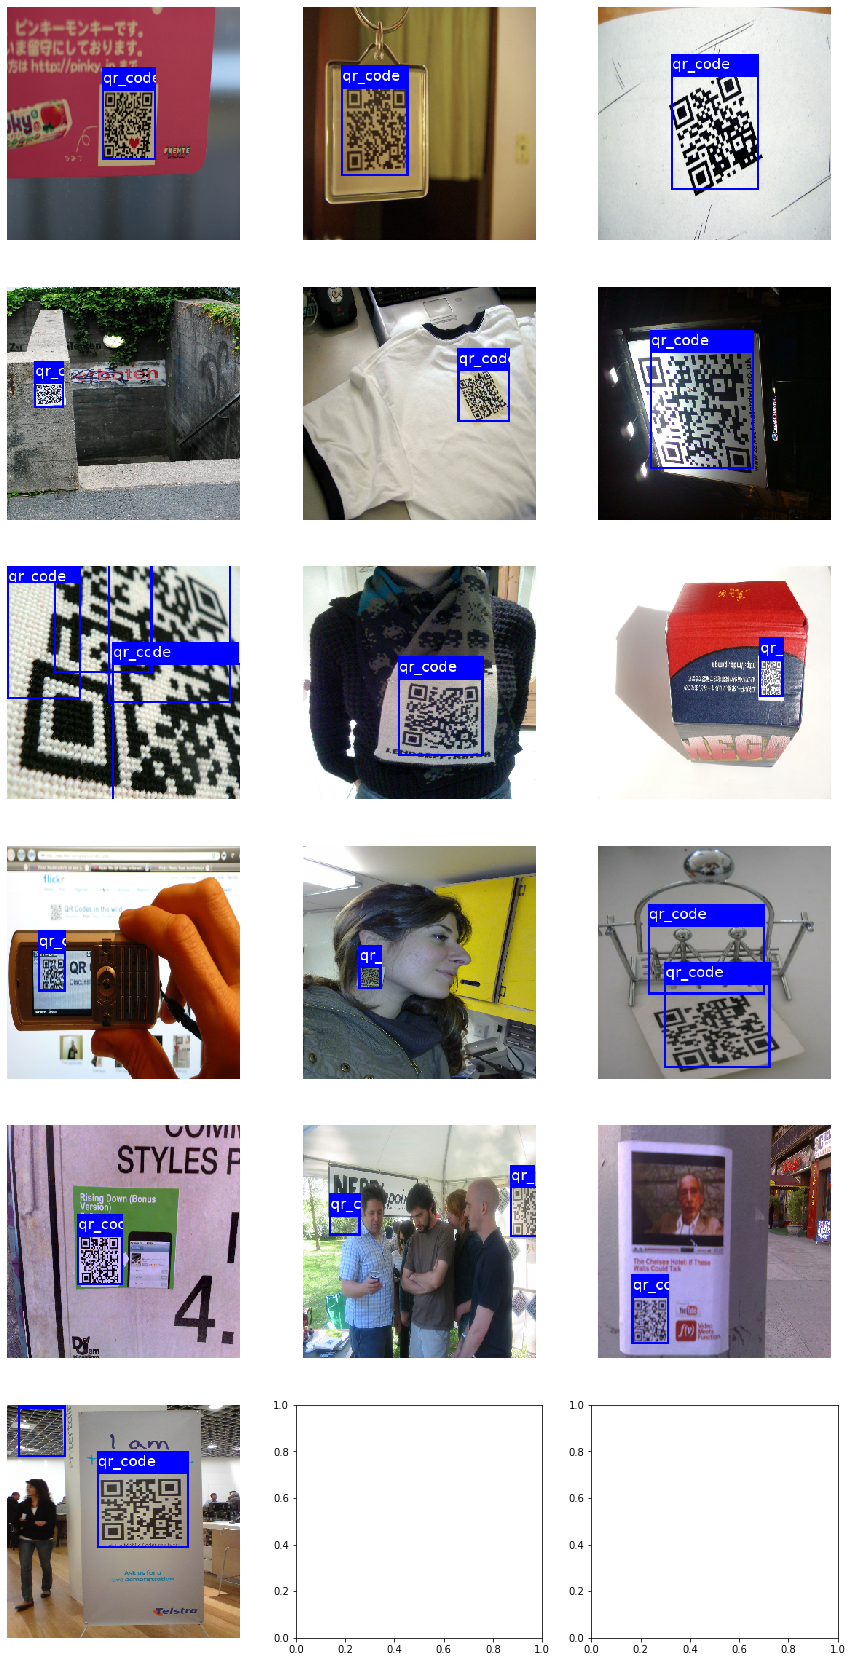

In [18]:
model_file = 'baseline_resnet50.h5'
model.load_weights(model_file)

from ssd_utils.metrics import mean_AP

ground_truth, predictions = [], []
        
for x, y_true in batched_test_data:
    predictions += [output_encoder.decode(y, anchors, model, nms_threshold=0.2)
                    for y in model(x)]
    ground_truth += [y.to_tensor() for y in y_true]

print('Validation meanAP:', mean_AP(ground_truth, predictions))

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(batched_test_data)
X, Y = next(data_iter)

for idx in range(num_display):
    x, y = X[idx], predictions[idx]
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()